[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/julclu/CSC509/blob/spring_2024/Module0/2_15_2023_Module0_Notebook2_SimpleClassification.ipynb)

## Problem definition: Simple classification of Brain images into MRI vs PET


In this jupyter notebook, you will learn to build a basic classification model using convolutional neural netowrks to classify  medical images generated from two different modalities namely PET and MRI. We will be using the Keras API for the classification.

In order to enable ease of access we have converted all the DICOM formatted images into JPEG format and randomly sorted them into training and test set.

## Some basics on classification problems
1. Classification problems can be set-up as a binary (eg. cat vs dogs) or multi-class (eg. cat, dog, chicken and turtle) classification.
2. In the current scienario we are doing a **Binary** classification as to whether an image is a MRI image or PET image.
3. In classification problems you should pay attention to the perfromance metrics such as Accuracy, area under reciever operating curve (AUROC) and area under precision recall curve (AUPRC). These metrics help us determine if our model is doing what we intended it for.
4. The above metrics are calculated based on if the lables are True positve/negative (TP/N) and Fasle postive/negative (FP/N). Your actual data only has True positives and negatives. False predictions are done by the model.
5. Depending on the context of the problem we might pick which perfromance metric to pay attention to. For instance, if we are interested in predicting if a person has cancer or not -based on health record, it is very important that we dont miss someone with cancer (True Negative) than predicting a healthy person as cancerous (False Positve).
Let's define it more in numbers: Let's say we would like to predict if a person has cancer or not based on health record. And you are given 1000 data points to train with. Assume only 30 people in the data do actually have cancer. i.e. 30 TP and 970 TN, if we predict one of the 970 as having cancer it is considered False Positive (FP). We are more interested in finding people who have cancer over misclassifications and therefore we care more about the accuracy of predicting the one class over the other.
6. Most classification problems are set up similar to the example above. Notice we have data more on the non-cancerous people than cancerous one. This is called a class imbalance. When we have such a class imbalance it is important to pay attention to how we define the problem.

## Let's continue with the notebook we will lean more on the way.

In [ ]:
#Load packages
import numpy as np
import pandas as pd
import os
import math
import PIL
from pathlib import Path
import glob as gb
from collections import Counter

from tqdm import tqdm
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

import matplotlib.pyplot as plt
import matplotlib.image as img

Connect to the data source:

In [ ]:
!apt-get update -y && apt-get install -y fuse lsb-release; \
    curl -L -O https://github.com/GoogleCloudPlatform/gcsfuse/releases/download/v1.4.0/gcsfuse_1.4.0_amd64.deb; \
    dpkg --install gcsfuse_1.4.0_amd64.deb; \
    apt-get update; \
    apt-get clean;

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:11 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy/main Sources [2,257 kB]
Get:12 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy/main amd64 Packages [1,158 kB]
Get:13 http://security.u

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
project_id = 'sfsu-378805'
bucket_name = 'csc-509-image-files'
!gcloud config set project {project_id}

Updated property [core/project].


In [ ]:
!gsutil ls

gs://csc-509-image-files/


In [ ]:
!mkdir images

In [ ]:
!gcsfuse --implicit-dirs csc-509-image-files images

{"time":"05/01/2024 04:47:52.093959","severity":"INFO","msg":"Start gcsfuse/1.4.0 (Go version go1.21.5) for app \"\" using mount point: /content/images\n"}


In [ ]:
!ls images/

Archive				Module0_UPENNGBM  Module1_BraTS.tar.bz2  Module2_ADNI
Module0_MRI_PET_Classification	Module1_BraTS	  Module1_PET		 Module2_ADNI_New


In [ ]:
train= '/content/images/Module0_MRI_PET_Classification/TRAIN/'
test = '/content/images/Module0_MRI_PET_Classification/TEST/'

Lets check how many images there are under each label in training and validation sets

In [ ]:
num_MRI_train_pts = len(gb.glob(train+'MRI/*.jpg'))
num_MRI_test_pts = len(gb.glob(test+'MRI/*.jpg'))
print('There are {} MRI images in the training folder'.format(num_MRI_train_pts)+'\n'+
      'and {} in the test folder'.format(num_MRI_test_pts))


num_PET_train_pts = len(gb.glob(train+'PET/*.jpg'))
num_PET_test_pts = len(gb.glob(test+'PET/*.jpg'))
print('There are {} PET images in the training folder'.format(num_PET_train_pts)+'\n'+
      'and {} images in the test folder'.format(num_PET_test_pts))

There are 10715 MRI images in the training folder
and 1122 in the test folder
There are 1155 PET images in the training folder
and 130 images in the test folder


As you can see there is a large class imbalance, we have more MRI images than we have PET images. These images are in gray scale and have different patient data, let take a look at few of training images. Note for every 1 PET image we have about 10 MRI images. Our model then can easily be skewed to just learn how to identify MRI images. And if our goal is actully to get data from PET images then the model would not be very helpful. In such a scienario we care more about the minor class than the majority class. Below let's define a function for plotting the images in the grid.

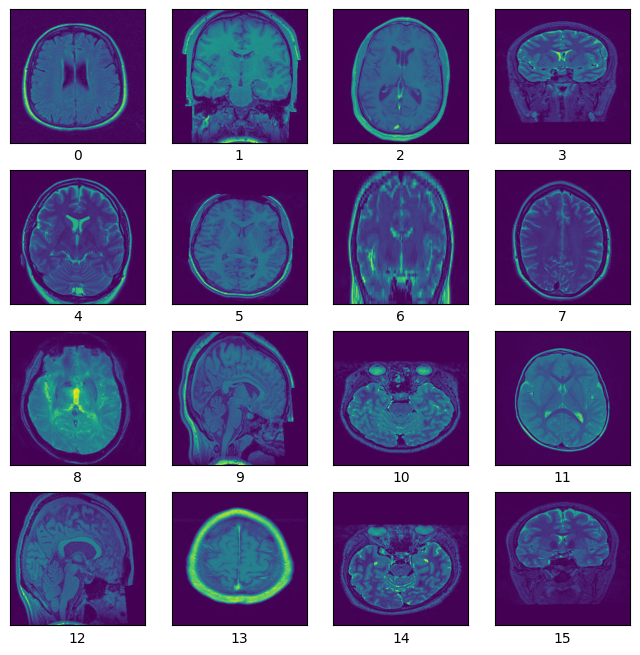

In [ ]:
mri_train = gb.glob(train+'MRI/*.jpg')
pet_train = gb.glob(train+'PET/*.jpg')
mri_test = gb.glob(test+'MRI/*.jpg')
pet_test = gb.glob(test+'PET/*.jpg')


def plot_grid(n,files):
  # takes argument n of the n x n grid and the list of files
  plt.figure(figsize=(8,8))
  for i in range(n*n):
    plt.subplot(n,n,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #MRI images
    idx=np.random.randint(len(files))
    plt.imshow(img.imread(files[idx]),aspect='auto')
    plt.xlabel(i)
  plt.show()


# lets plot mri_train
plot_grid(4,mri_train)

Lets look at the test set as well. Note the test and train data have been downloaded from ADNI dataset:
- http://adni.loni.usc.edu/
- https://fastmri.med.nyu.edu/
- https://openneuro.org/


In future if you'd like to get medical imaging data you use the following sources:

- https://fastmri.med.nyu.edu/
- https://openneuro.org/
- https://www.cancerimagingarchive.net/
- https://www.aylward.org/notes/open-access-medical-image-repositories

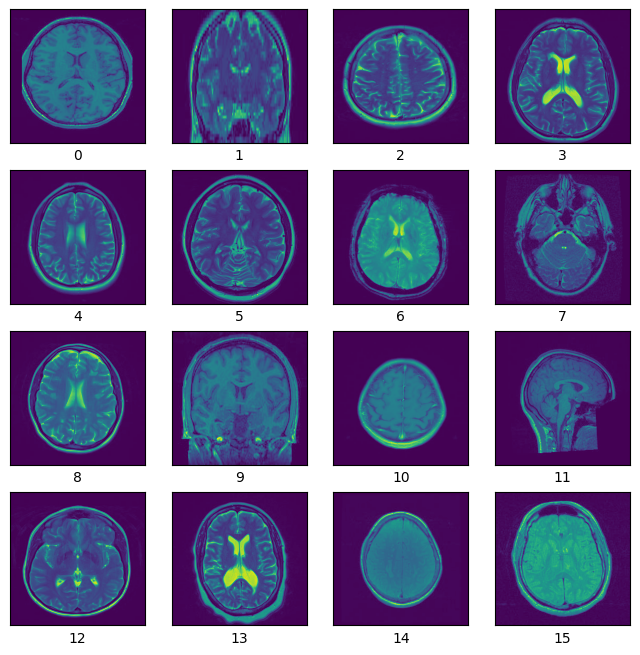

In [ ]:
plot_grid(4,mri_test)

Lets look at the PET image training set likewike

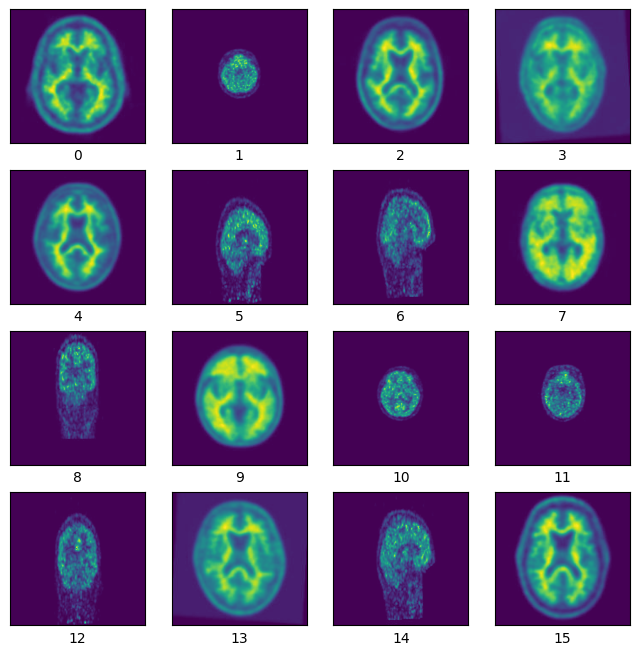

In [ ]:
plot_grid(4,pet_train)

As you can see the images in the MRI data and the PET dataset are quite distinct from each other. As we learned earlier in the lecture 2 and 3 there are fundemental differences between what is getting imaged and how it is captured/processed. We want the CNN to learn this(well sort of).

**Look at the PET test data on your own in the below code block**

Next, let's load these images off disk as an image-generator object from keras api. The *`ImageDataGenerator()`* class has a convinient function  `flow_from_directory()` utility that can infer the data classes based on the subfolders in the directory. In paractive *`ImageDataGenerator()`* can be used for data agumentation, but we will not be needing this at the moment.

**Note** the target size parameter it is set to 256 X 256 which means we are asking Keras to read all the images at that resolution. This is also the dimensions of the first layer in your CNN, so if you would like for the training to run faster or slower you can tweak this parameter. But I reccomend not changing this.

We will be splitting images in the train folder into 70% train and 30% validation set.

##`Image Normalization`

One of the key steps in working with image data is to normalize the rbg pixel values stored in the pixel array. For RBG format images the value can range from 0 to 255, and it is typical to rescale this to 0-1. *(The jpg formatted images were read from DICOM slices and have already been normalized before saving them.)*

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0,validation_split=0.3) # set validation split
classes = ['MRI', 'PET'] # class labels
image_size=(256,256) #image size
train_ds =  train_datagen.flow_from_directory(
  train,
  subset="training",
  seed=123,
  classes=classes,
  target_size=image_size,
  batch_size=32,
  interpolation="lanczos")

Found 8310 images belonging to 2 classes.


Similarly lets create test and validation set. This is the 30% subset of the training data and you will use the same data generator.

Once you finish going through this notebook: **As a homework play around with a 60/40 50/50 spilt. Notice the seed parameter it is included to improve the reproducablity of the training and validation split. If you dont specify it the code will pick a random number and everytime you run this it will give you a different result.**

In [ ]:
valid_ds = train_datagen.flow_from_directory(
  train,
  subset="validation", seed=123,
  classes=classes,
  target_size=image_size,
  batch_size=32,
  interpolation="lanczos")

Found 3560 images belonging to 2 classes.


Finally we need an the idependent test set that is not used in training or validation. **!!! Very important in the test data make sure shuffle=False --- if not you will get spurious confusion matrix !!!**

In [ ]:
# Test set will not be shown to the model
#it will be used to calculate performance on the trained model
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_ds = test_datagen.flow_from_directory(test, classes=classes,target_size=image_size,batch_size=100,shuffle=False)

Found 1252 images belonging to 2 classes.


These 1252 images will be used to check the model performance. We talked about normalization, lets check if the images are indeed normalized.

In [ ]:
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9960785


The pixel values range from 0-1 so the pixels are indeed normalized. Let's take a look at how the class label for the images are stored. As you can see below the label is a 1D numpy array with two columns each corresponding to the truth value of the class i.e. `[1.,0.] `represents the image is a MRI and `[0.,1.]` represents the image is a PET image. This in ML parlance is known as one-hot enncoding. The label is a vector where values are zero for all classes except the one to which the sample belongs to. This is very convinient to use even in multi-class classifier tasks.

In [ ]:
labels_batch[0]

array([1., 0.], dtype=float32)

Let's take a look at the images from the keras imagedatagenerator with their lables. I have a dictionary mapped with the label names for clarity. Recall that we read the data into keras in batches of 32 images.

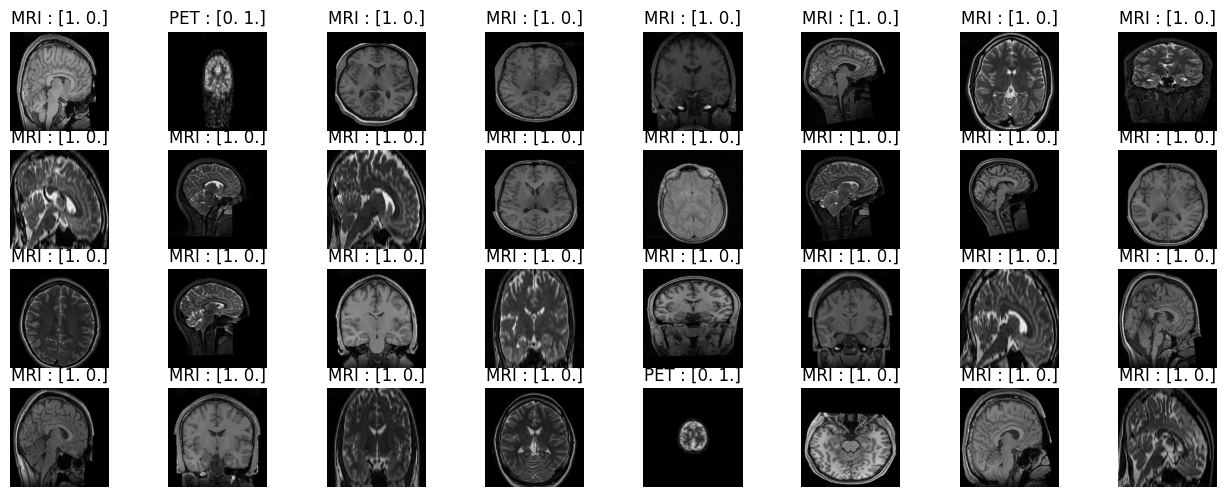

In [ ]:
v = np.arange(2.0)
label_dict = {
    str(np.flip(v)):'MRI',
    str(v):'PET'
    }

image_batch, labels_batch = next(iter(train_ds))
plt.figure(figsize=(16,9))
k=1
for i,j in zip(image_batch, labels_batch):
  ax = plt.subplot(6,8,k)
  plt.imshow(i)
  plt.title(label_dict[str(j)]+" : "+str(j))
  plt.axis("off")
  k+=1

The `image_batch` is a tensor of the shape `(32, 256, 256, 3)`. This is a batch of 32 images of shape `256x256x3` (the last dimension `3` refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,2)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`

In [ ]:
print(image_batch.shape)
print(labels_batch.shape)

(32, 256, 256, 3)
(32, 2)


Next lets move on to specifiying our model, recall the basics of convolutional neural netowrk. To gain more indepth understanding/refresher I reccomend this following video: https://www.youtube.com/watch?v=aircAruvnKk

In simple terms we assume there is a nonlinear relationship between the input variables (pixels) and the output (lables: PET/MRI). CNN's pass the information from one layer to the other via an activation function. We typically use Rectified Linear Unit (ReLu) activation function, this is one of the popular functions https://keras.io/api/layers/activations/. Information from the top layer gets passed on to the next layer only if it satisfies the activation function. Watch the video to get a better understanding.

In our scienario we are passing a 256x256 2D pixel array that contains RGB channel values as the starting layer that passes through 3 convolutions and 3 maxpooling layers in sequence. Followed by a dense layer that identifies the two classes in our data based on softmax activation.

Let's continue with the model...

In [ ]:
model = Sequential([
  layers.InputLayer(input_shape=(256,256,3)),
  layers.Dense(32,activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(64,(3,3),activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(64,(3,3),activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Flatten(),
  layers.Dense(32,activation='relu'),
  layers.Dense(2, activation='softmax')
])

We specifiy the parameters for each of this layer consider this line of code:

`layers.Conv2D(32, (3,3), padding='same', activation='relu')`

Here,
- **32** specifies the number **fliters** to be used in the layer
- **(3,3)** represents the **kernel_size** (dimensions) 3X3 this is always an odd number
- **padding** controls how the input volume is padded with zeros and allowed to change, "same" specifies that we would like to keep the shape of the input volume.
- **activation** specifies the activation function we would like to use. Try out a different activation function and see how the results change.

The kernel size parameter of 3X3 is the most popular choice with a good trade off between coverage and training speed. You can increase this to 5X5 but would result in longer training time computations. People have used 11X11 in the past with week long training times. The choice and size of kernel decides the sharpness and details of the feature we want to capture.

**Check this website out it visually follows a CNN during image classification task https://poloclub.github.io/cnn-explainer/**

I have tried to explain the kernel size here with a simple example below.

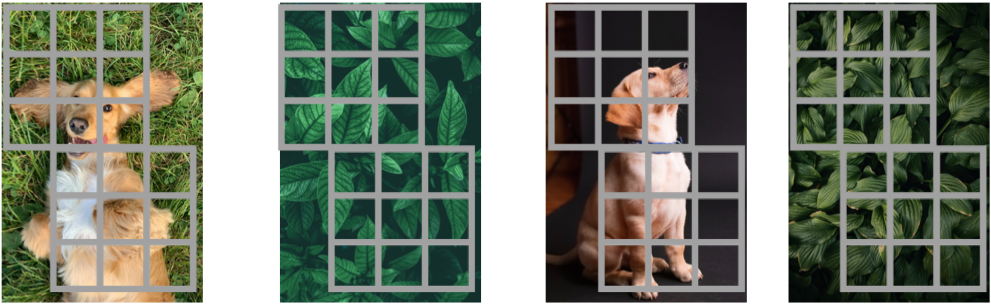

Lets assume you have the task of identifying images with dog and images with plants. I have provided an example above. We are choosing a 3X3 kernel which will slide over the image and convolute the features that are pixel value. The pictures are distinct enough that the grid will caputure brown + green/black = Dog and Green = Plant (this is a simple approximation !! Don't question it)

But consider task below, we want to identify which plant does the leaf belong to...

 >(Also check out this app: https://www.picturethisai.com/ which actually performs this task)

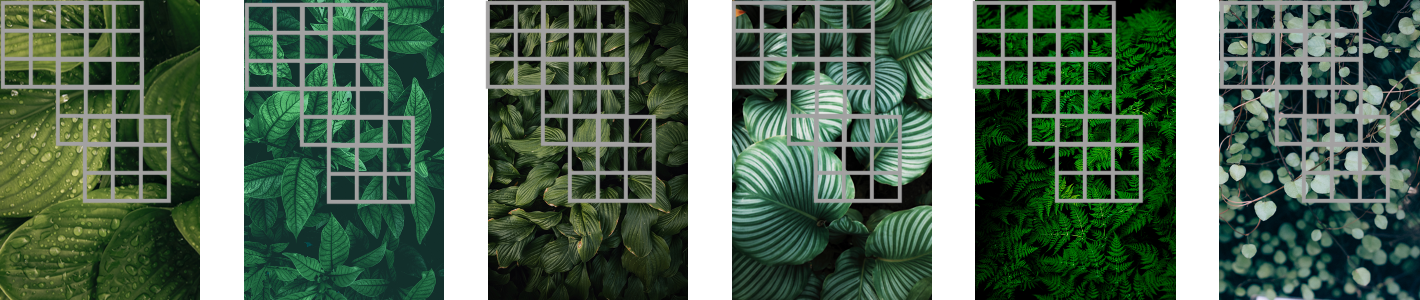

In this case a 3X3 grid can still work but our model may not perform very well because there is long correlations i.e. pixel information on the current grid has correlations beyond the 3X adjacent grid. In the first image the 3X3 grid will only observe green values at differnet gradient. If we expand the grid size it is likely we will do a better job at identifying which plant this is like the image below:

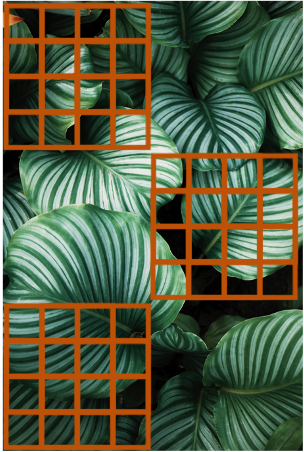

Another option is to use dialated convolutions, where we have a wider grid. In simple terms, dilated convolution is just a convolution applied to input with defined gaps. With this definitions, given our input is an 2D image, dilation rate k=1 is normal convolution and k=2 means skipping one pixel per input and k=4 means skipping 3 pixels. The best to see the figures below with the same k values.

The figure below shows dilated convolution on 2D data. Red dots are the inputs to a filter which is 3×3 in this example, and green area is the receptive field captured by each of these inputs. Receptive field is the implicit area captured on the initial input by each input (unit) to the next layer .

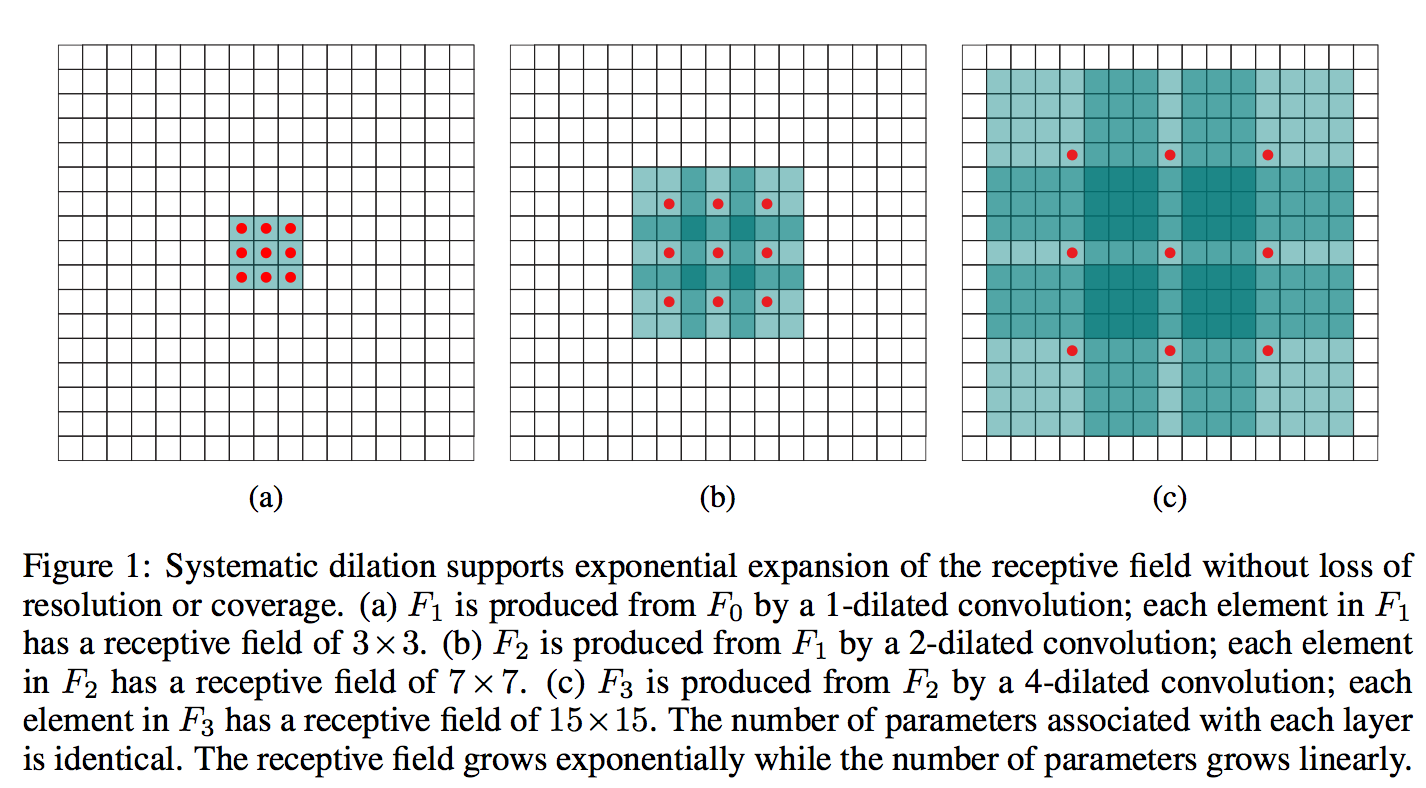

in the leaf examples this would look like

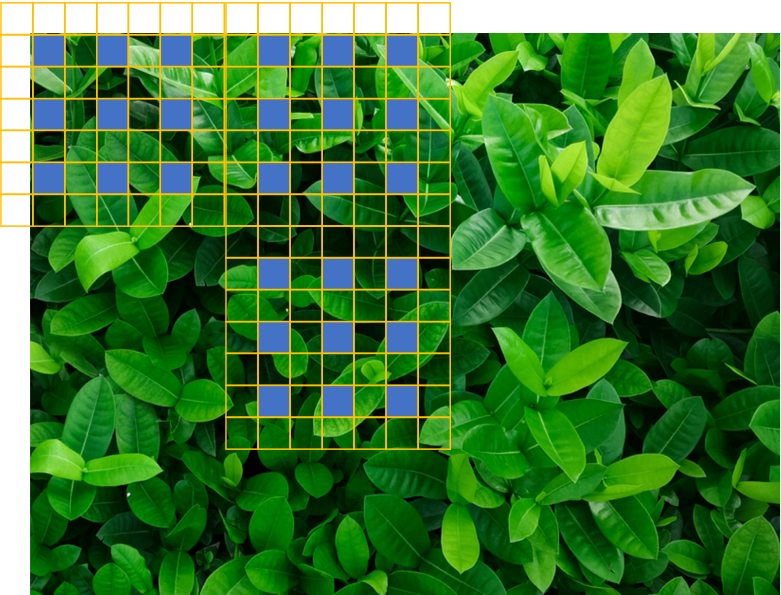

Lets look at the summary of the model we specified.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256, 256, 32)      128       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)        0

You can see that the input tensor 256 X 256 X 3 is getting converted to 128 X 128 X 32 in the first convolution. But as we progress, the convolution layers increase while the N X N grid size decreases. Check out this page to get more intituion on what's happening: https://poloclub.github.io/cnn-explainer/

More details are covered in the lecture.

Let's compile the model. We have to pick an optimizer and loss function to compile the model. For this tutorial, choose the `tf.keras.optimizers.Adam `optimizer and `tf.keras.losses.BinaryCrossentropy` loss function. This loss function is ideal for scienarios where we only have 2 classes in the dataset. To view training and validation accuracy for each training epoch, pass the metrics argument to `Model.compile`. You can read more about these options here:

> https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
> https://www.tensorflow.org/api_docs/python/tf/keras/losses/

These are also some parameters you can play with to see how the performance of the model changes. Finally the metrics parameter specifies how we want to frame the problem. Recall the introduction. Lets pick accuracy which is a balance between both the classes.

In [ ]:
lr = 0.001
num_steps_per_epoch = 100
num_validation_steps = 20
num_epochs = 5
model.compile(Adam(learning_rate = lr),
              # optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

Now lets train the model in 5 epochs.

In [ ]:
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  validation_steps=num_validation_steps,
  epochs=num_epochs, verbose=2
)

Epoch 1/5


Below are two convinient functions you can use to access the training perfromance and model perfromance

In [ ]:
def training_performance(history,epochs,metric_list):
  ## Takes history and metric_list, returns figure object
  metric_list.append('loss')
  train_metric = {}
  valid_metric = {}
  epoch_ranges = range(epochs)
  n_metric = len(metric_list)
  fig = plt.figure(figsize=(5*n_metric, 4))
  j = 1
  for i in metric_list:
    train_metric[i] = history.history[i]
    valid_metric[i] = history.history['val_{}'.format(i)]
    plt.subplot(1,n_metric,j)
    plt.plot(epoch_ranges,train_metric[i], label='Training_{}'.format(i))
    plt.plot(epoch_ranges,valid_metric[i], label='Validation_{}'.format(i))
    plt.legend(loc='lower right')
    plt.title('Training_Valdiation_{}'.format(i))
    j+=1
  return fig

def test_performance(y_test,y_pred):
  ## Takes test labels and predicted lables returns
  ## Returns confusion matrix plot, ROC, PR plots
  from sklearn.metrics import classification_report,confusion_matrix, \
                              ConfusionMatrixDisplay, accuracy_score, auc
  from sklearn.metrics import roc_curve as roc
  from sklearn.metrics import RocCurveDisplay
  from sklearn.metrics import precision_recall_curve as pr
  from sklearn.metrics import PrecisionRecallDisplay as prd
  target_names = ['MRI', 'PET']
  fig,axes = plt.subplots(1, 3, figsize=(16, 4))
  ## Confusion Matrix
  cm = confusion_matrix(y_test,y_pred)
  print("Confusion Matrix \n \
         \n MRI  \t {} \
         \n PET_Predicted_as_MRI \t {} \
         \n MRI_Predicted_as_PET \t {} \
         \n PET \t {} \n".format(cm[0][0],cm[0][1],cm[1][0],cm[1][1]))

  print ("Overall Accuracy of the model: {:.3f}".format(accuracy_score \
                                          (y_test,y_pred)))
  cmd = ConfusionMatrixDisplay(cm, display_labels=target_names)
  cmd.plot(ax=axes[0])
  cmd.ax_.set(xlabel='Predicted', ylabel='Test', \
            title='Confusion matrix' )
  cmd.im_.colorbar.remove()
  ## ROC curve
  fpr, tpr, thresholds = roc(y_test,y_pred)
  auroc = auc(fpr,tpr)
  roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr, \
                           roc_auc=auroc,estimator_name='CNN_MRI_PET')
  roc_plot.plot(ax=axes[1])
  roc_plot.ax_.set(xlabel='False Postive Rate', ylabel='True Postive Rate')
  roc_plot.figure_.suptitle('ROC')

  ## Precision-Recall
  precision, recall, _ = pr(y_test,y_pred)
  auprc = auc(recall,precision)
  pr_plot = prd(precision=precision, recall=recall)
  pr_plot.plot(ax=axes[2],name='PR AUC={:.3f}'.format(auprc))
  pr_plot.ax_.set(xlabel='Recall', ylabel='Precision')
  pr_plot.figure_.suptitle('Precision-Recall Curve')

  return fig

Lets check how the model has trained. We can do this by plotting the accuracy between traing data and validation data

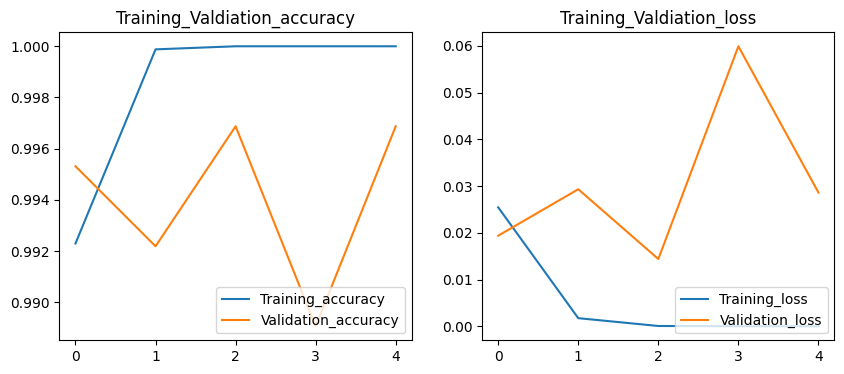

In [ ]:
a = training_performance(history,num_epochs,['accuracy'])

Get the test labels for the images

In [ ]:
y_test = test_ds.labels

Make predictions for the test data

In [ ]:
predictions = model.predict(x=test_ds, verbose=1)

13/13 [==============================] - 69s 6s/step


Remember the model actually perdicts probablity for class 0 vs 1 and as per our specification class 0 is MRI and class 1 is PET images. But if you check the  test_ds.labels you will see 1D array

In [ ]:
print(len(test_ds.labels))
test_ds.labels

1252


array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

the labels are actual lables 0 corresponding to MRI and 1 corresponding to PET. We just have to get the probablity of the 1st colum from the perdictions

In [ ]:
predictions

array([[1.0000000e+00, 1.3115076e-26],
       [1.0000000e+00, 9.0698548e-37],
       [1.0000000e+00, 2.6743888e-26],
       ...,
       [2.1526014e-09, 1.0000000e+00],
       [2.6344925e-12, 1.0000000e+00],
       [6.5664345e-12, 1.0000000e+00]], dtype=float32)

In [ ]:
y_pred = np.round(predictions[:,1])

You can aslo use the model.evaluate function to test the model accuracy and loss

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
                                     #verbose=0)
print(test_loss)
print(test_acc)

13/13 [==============================] - 9s 727ms/step - loss: 0.0031 - accuracy: 0.9984
0.0031335006933659315
0.9984025359153748


As you can see the model predicts the correct label 99.6% of the times

Now let's test the performance of the model, we will plot the confusion matrix to actually visualize the perfromance

Confusion Matrix 
          
 MRI  	 1120          
 PET_Predicted_as_MRI 	 2          
 MRI_Predicted_as_PET 	 0          
 PET 	 130 

Overall Accuracy of the model: 0.998


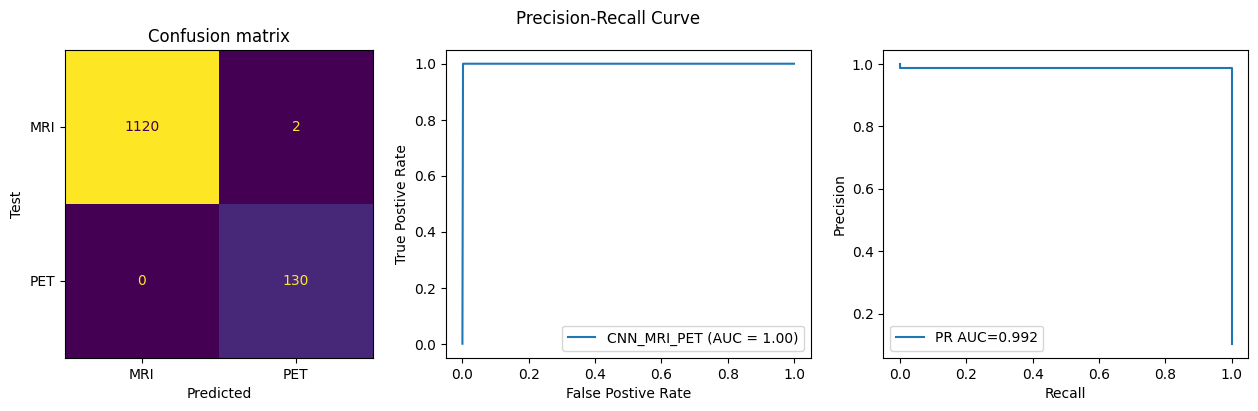

In [ ]:
b = test_performance(y_test,y_pred)